# Azure Cognitive Services : Text Analytics API

In this notebook, we will use the [Azure Cognitive Services Text Analytics API - Sentiment Analysis](https://docs.microsoft.com/en-us/azure/cognitive-services/text-analytics/overview) to predict the sentiment of the tweets.

We will compare this pre-trained cloud model to the baseline model from [main.ipynb](main.ipynb).

## Load project modules and data

We will use basic python packages, and the [`azure`](https://pypi.org/project/azure/) package to access the Azure Cognitive Services Text Analytics API. The secrets are stored in the `.env` file.

In [1]:
# Import custom helper libraries
import os
import sys

# Maths modules
import pandas as pd


src_path = os.path.abspath(os.path.join("../src"))
if src_path not in sys.path:
    sys.path.append(src_path)

import features.helpers as feat_helpers
import data.helpers as data_helpers
import visualization.helpers as viz_helpers


# Load environment variables from .env file
from dotenv import load_dotenv

load_dotenv()
AZURE_TEXT_ANALYTICS_KEY=os.getenv("AZURE_TEXT_ANALYTICS_KEY")
AZURE_TEXT_ANALYTICS_ENDPOINT=os.getenv("AZURE_TEXT_ANALYTICS_ENDPOINT")

# Sample data for development
TEXT_SAMPLE_SIZE = 1000  # <= 0 for all


In [2]:

# Download and unzip CSV files
!cd .. && make dataset && cd notebooks


>>> Downloading and extracting data files...
Data files already downloaded.
>>> OK.



In [3]:
# Load data from CSV
df = pd.read_csv(
    os.path.join(
        "..", "data", "raw", "training.1600000.processed.noemoticon.csv"
    ),
    names=["target", "id", "date", "flag", "user", "text"],
)

# Reduce memory usage
df = data_helpers.reduce_dataframe_memory_usage(df)

# Drop useless columns
df.drop(columns=["id", "date", "flag", "user"], inplace=True)

# Replace target values with labels
df.target.replace(
    {
        0: "NEGATIVE",
        2: "NEUTRAL",
        4: "POSITIVE",
    },
    inplace=True,
)

# Sample data
if TEXT_SAMPLE_SIZE > 0:
    # Stratified sampling
    df = (
        df.groupby("target", group_keys=False)
        .apply(
            lambda x: x.sample(
                n=int(TEXT_SAMPLE_SIZE / df.target.nunique()), random_state=42
            )
        )
        .reset_index(drop=True)
    )

df.describe()


,target,text
count,1000,1000
unique,2,1000
top,NEGATIVE,@xnausikaax oh no! where did u order from? tha...
freq,500,1


## Classification Model

Now we can measure the performance of our model defined in [custom_azure_text_analysis_classifier.py](../src/models/custom_azure_text_analysis_classifier.py). We are going to use the same metrics as our baseline model defined in [main.ipynb](main.ipynb).

/home/clement/Workspace/oc_p7/env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.

/home/clement/Workspace/oc_p7/env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.

/home/clement/Workspace/oc_p7/env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.R

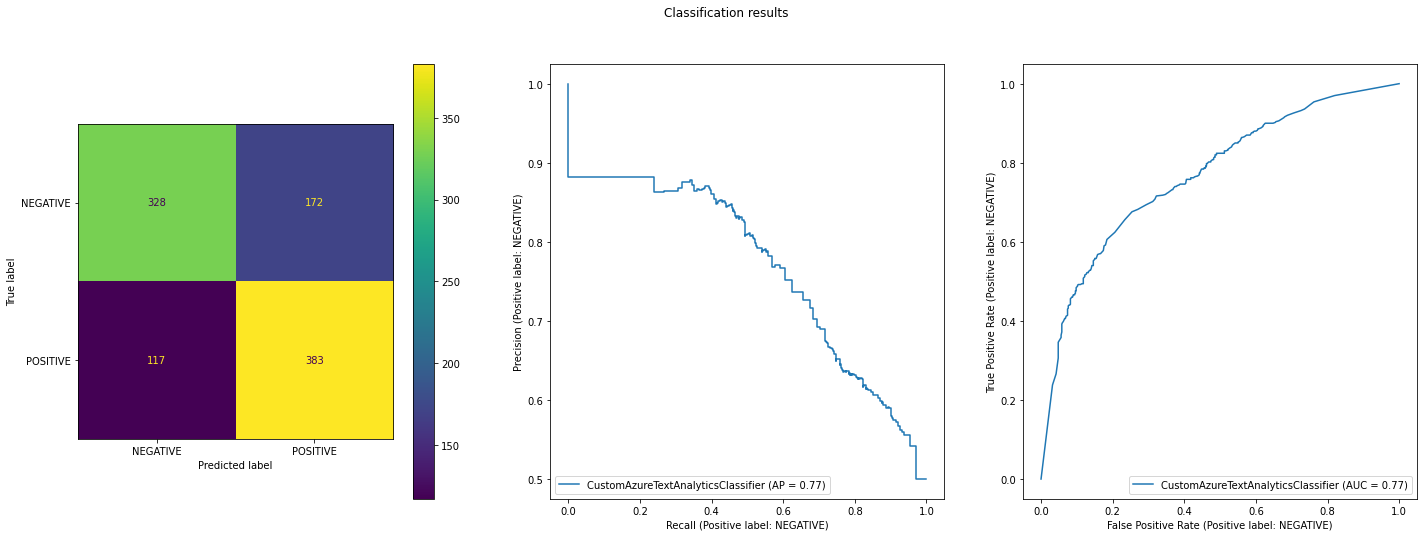

In [5]:
from models.custom_azure_text_analysis_classifier import (
    CustomAzureTextAnalyticsClassifier,
)


cls = CustomAzureTextAnalyticsClassifier(
    endpoint=AZURE_TEXT_ANALYTICS_ENDPOINT, key=AZURE_TEXT_ANALYTICS_KEY
)

cache_json_path = os.path.join("..", "results", "analyze_sentiment_cache.json")
if os.path.exists(cache_json_path):
    cls.load_cache_json(filename=cache_json_path)

cls.fit(X=df.text.values, y=df.target.values)

cls.save_cache_json(filename=cache_json_path)


viz_helpers.plot_classifier_results(
    cls,
    df.text.values,
    df.target.values,
    title="Classification results",
)


The performances on the dataset are slightly better than our baseline model : 
- Average Precision = 0.77 (baseline = 0.74 , +4,1%)
- ROC AUC = 0.77 (baseline = 0.75 , +2,7%)

This model is also biased towards the positive class, but less than our baseline model : it predicted 25% (baseline = 35% , -10%) more _POSITIVE_ (555) messages than _NEGATIVE_ (445).
